<a href="https://colab.research.google.com/github/GabyDs/EjerciciosInteligenciaComputacional/blob/main/Lab2Ej2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiencia 2

## Consigna

Se tiene un dataset con información relacionada a un conjunto de personas de diferentes edades,
etnias y géneros. Además, se cuenta con un canal de la imagen, a partir del cual se obtienen cada uno
de estos valores.

Los datos se encuentran tabulados en un archivo del tipo “.csv”, se disponen de más de 23.000
observaciones.

El dataset presenta la siguiente estructura:
* age: numérico, edad de la persona de la imagen.
* ethnicity: categórica, etnia a la que pertenece la persona.
* gender: categórica, género de la persona.
* pixels: arreglo de 48x48 elementos, píxeles codificados en 8 bits.

Conformar una red neuronal
artificial (RNA) con la capacidad de predecir al menos dos de las características tabuladas (edad, etnia,
género). Algunos tipos de datos necesitarán ser transformados, por lo tanto, previo al proceso de
entrenamiento, será necesaria una etapa de inspección/exploración y tratamiento de la información.

Durante la experiencia, responder las siguientes cuestiones:
* ¿Qué tipo de capas son fundamentales en una RNA que procesa imágenes? ¿Por qué?
* Una misma RNA ¿Puede predecir más de una característica?
* ¿A partir de qué tamaño la RNA logra desempeñar con cierta eficiencia la tarea
encomendada?

## Desarrollo

### Importacion de Librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Preprocesamiento

In [2]:
# Comprimido pesa bastante menos, conviene subirlo así y descomprimir
# También se puede linkear al Drive desde Colab
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1kWUodrpx2nolRxwld9aa9kPLE6MbGFud&confirm=t" -O age_gender.zip
!unzip -qq age_gender.zip

--2023-05-16 01:56:07--  https://drive.google.com/uc?export=download&id=1kWUodrpx2nolRxwld9aa9kPLE6MbGFud&confirm=t
Resolving drive.google.com (drive.google.com)... 142.251.10.113, 142.251.10.101, 142.251.10.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.10.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6stfc53u13lc7pfuvku9k6s7uodlpdoq/1684202100000/12225850433951268217/*/1kWUodrpx2nolRxwld9aa9kPLE6MbGFud?e=download&uuid=e4a7439c-7c2e-4daf-89e9-0b06502af4f3 [following]
--2023-05-16 01:56:09--  https://doc-14-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6stfc53u13lc7pfuvku9k6s7uodlpdoq/1684202100000/12225850433951268217/*/1kWUodrpx2nolRxwld9aa9kPLE6MbGFud?e=download&uuid=e4a7439c-7c2e-4daf-89e9-0b06502af4f3
Resolving doc-14-9c-docs.googleusercontent.com (doc-14-9c-docs.googleusercontent.com)... 142.251.12.

In [3]:
dataset = pd.read_csv("age_gender.csv")
dataset = shuffle(dataset) # Mezclado, pareciera que estaba ordenado por edades
dataset.reset_index(inplace=True, drop=True) # Restablecer índices
dataset.head()

,age,ethnicity,gender,img_name,pixels
0,38,0,0,20170104170126057.jpg.chip.jpg,58 89 123 127 137 136 137 143 148 152 154 156 ...
1,35,2,0,20170116172936477.jpg.chip.jpg,23 18 13 16 15 21 34 40 60 24 43 87 109 125 13...
2,48,0,0,20170104182220669.jpg.chip.jpg,87 86 85 81 41 26 36 69 86 103 111 113 130 149...
3,22,3,0,20170119162807109.jpg.chip.jpg,15 10 7 6 6 5 17 21 27 27 43 56 68 75 76 82 88...
4,35,0,0,20170119201414564.jpg.chip.jpg,158 109 96 112 144 174 191 185 175 164 151 139...


In [4]:
dataset.info()
# Nada de nulos, del tipo objeto se tiene pixels solamente de las columnas que nos interesan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [5]:
# Conversion de la informacion de las imagenes para poder operar
dataset['pixels'] = dataset['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))

Edad: 29 - Etnia: 3 - Genero: 1


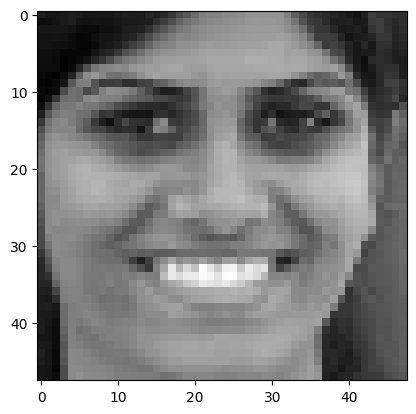

In [6]:
# Pruebas sobre la conversión

random = 444
plt.imshow(dataset['pixels'][random].reshape(48, 48), cmap='gray')
print("Edad: {} - Etnia: {} - Genero: {}".format(dataset['age'][random], dataset['ethnicity'][random], dataset['gender'][random]))

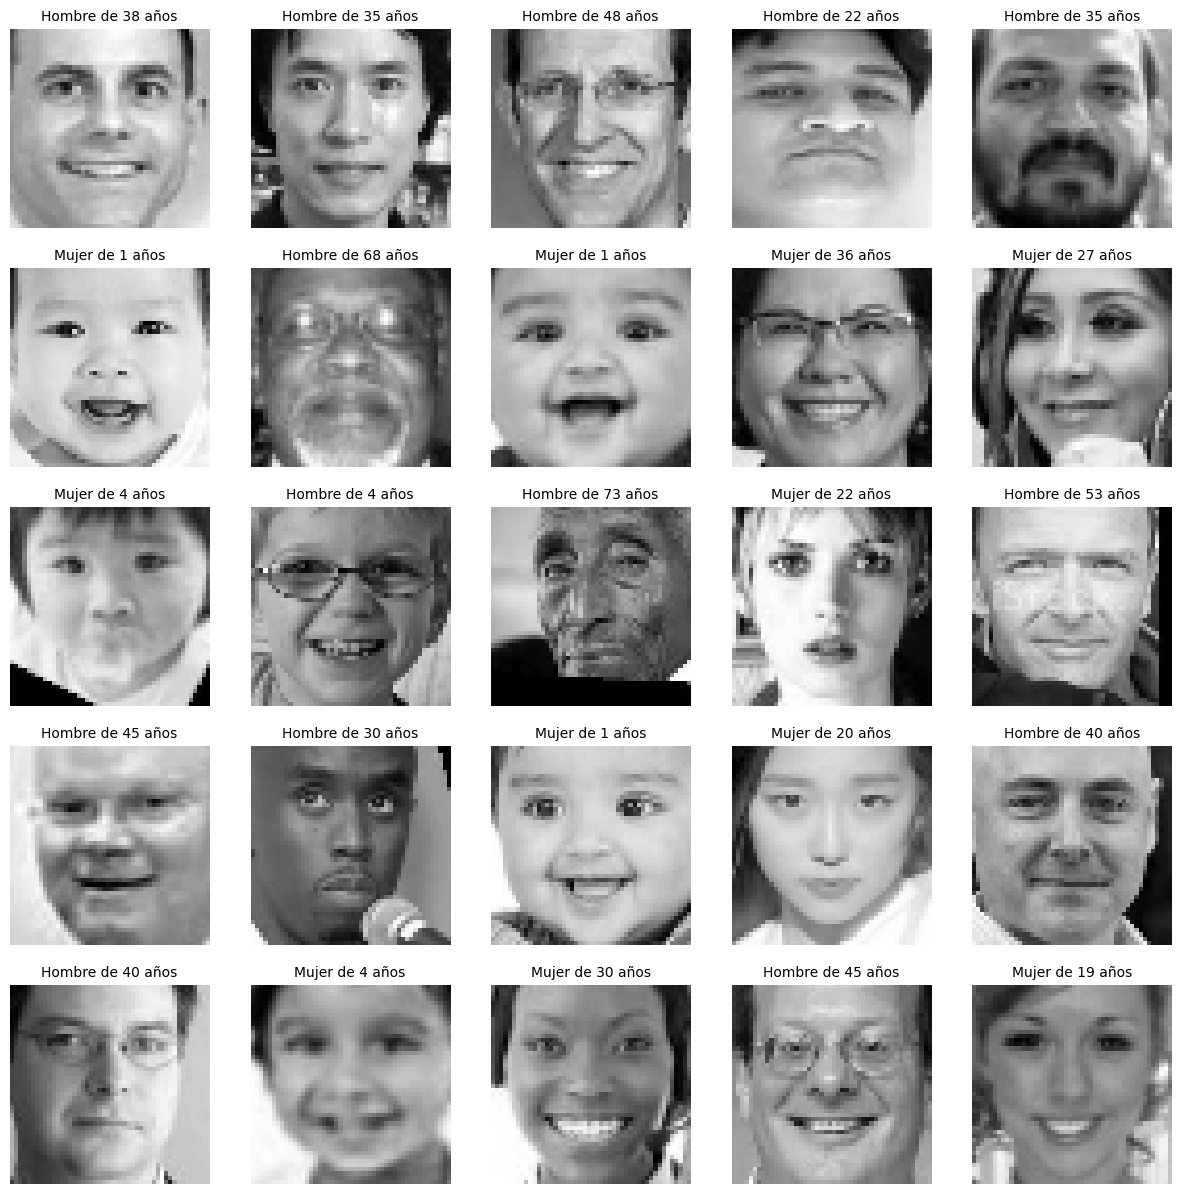

In [7]:
# Visualización general

generos = ['Hombre', 'Mujer'] # "0" para Hombre y "1" para Mujer según dataset

plt.figure(figsize=(15,15))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(dataset['pixels'][i].reshape(48, 48), cmap='gray')
    gend = generos[int(np.array(dataset['gender'])[i])]
    plt.title('{} de {} años'.format(gend, np.array(dataset['age'])[i]), fontsize = 10)

### Division de sets

In [8]:
# División del dataset
x = np.array(dataset['pixels'].tolist())
x = np.reshape(x, (-1, 48, 48,1))
y = dataset['age']
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y, test_size=0.3, random_state=1)

x_train_age, x_val_age, y_train_age, y_val_age = train_test_split(x_train_age, y_train_age, test_size=0.4, random_state=1)

In [9]:
x = np.array(dataset['pixels'].tolist())
x = np.reshape(x, (-1, 48, 48, 1))
y_age = dataset['age']
y_gender = dataset['gender']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.3, random_state=1)
x_train_age, x_val_age, y_train_age, y_val_age = train_test_split(x_train_age, y_train_age, test_size=0.4, random_state=1)

train_datagen = ImageDataGenerator(rescale=1/255)
train_generator_age = train_datagen.flow(x_train_age, y_train_age, batch_size=64)

val_datagen = ImageDataGenerator(rescale=1/255)
val_generator_age = val_datagen.flow(x_val_age, y_val_age, batch_size=64)

x_test_age = x_test_age / 255

In [10]:
# Escalado y y creación de lotes
"""
Ya lo conté en el anterior Notebook, pero acá se va a notar bien qué pasa con el
tamaño del lote y las épocas.
Si el lote es grande, por épocas se realizan menos iteraciones. Las iteraciones
resultan de las agrupaciones necesarias para tomar todos los datos del set.
Ej. lote de 2048 se tienen 5 iteraciones por época
Ej. lode de 64 se tienen 156 iteraciones por época

Utilizando la división de ejemplo por supuesto.
"""

train_datagen = ImageDataGenerator(rescale=1/255)

"""
Se crea un objeto train_datagen de la clase ImageDataGenerator. 
Este objeto se utiliza para aplicar transformaciones y preprocesamiento a 
las imágenes de entrenamiento. En este caso, se utiliza el parámetro rescale 
para escalar los valores de píxeles de las imágenes dividiéndolos por 255, 
lo que normaliza los valores en el rango [0, 1].
"""

train_generator_age = train_datagen.flow(x_train_age, y_train_age, batch_size=64)

"""
Se crea un generador de datos de entrenamiento utilizando el objeto train_datagen. 
El método flow() toma como argumentos los datos de entrenamiento 
(x_train_age y y_train_age) y el tamaño del lote (batch size) que se utilizará 
durante el entrenamiento. El generador generará lotes de datos aumentados o 
preprocesados a medida que el modelo los requiera durante el entrenamiento.
"""

val_datagen = ImageDataGenerator(rescale=1/255)

"""
Se crea un objeto val_datagen de la clase ImageDataGenerator para el conjunto 
de datos de validación. Al igual que en el caso anterior, se utiliza el 
parámetro rescale para escalar los valores de píxeles de las imágenes de validación.
"""

val_generator_age = val_datagen.flow(x_val_age, y_val_age, batch_size=64)

"""
Se crea un generador de datos de validación utilizando el objeto val_datagen. 
Al igual que en el caso del generador de entrenamiento, se utilizan los datos 
de validación (x_val_age y y_val_age) y el tamaño del lote (batch size) especificado.
"""


x_test_age = x_test_age/255 # Aplico la misma transformación a los datos que uso para testear el modelo entrenado

### CRNA - modelos y parámetros

In [10]:
# Criterio de parada extra, épocas que espera sin mejorar para detener entrenamiento
earlystop = EarlyStopping(patience=10)

# Ajuste de tasa de aprendizaje automático
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

In [18]:
# Modelo de ejemplo

# Capas nuevas, especializadas para imágenes: Conv2D, MaxPooling2D, Flatten.

"""
Ver ejemplos y tipos:
    https://keras.io/api/layers/convolution_layers/
    https://keras.io/api/layers/pooling_layers/
    https://keras.io/api/layers/reshaping_layers/

En la última está Flatten, se utiliza para pasar de 2D a 1D en este caso.

Hay mucha información para la etapa de compilación, entrenamiento, etc.
"""

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))          
          
model.add(Flatten())
model.add(Dropout(0.5))            

#model.add(Dense(1, activation='relu'))    # La función de activación de la salida... ¿Juega un papel importante para la tarea que quiero realizar?
model.add(Dense(2, activation='relu'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) # mean absolute error (MAE), funciona para un lote grande?

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 64)        

**¿Qué tipo de capas son fundamentales en una RNA que procesa imágenes? ¿Por qué?**

1. Capas de convolución (Convolutional Layers): Estas capas aplican filtros convolucionales a la imagen de entrada para extraer características locales. Cada filtro detecta patrones específicos en la imagen, como bordes, texturas o formas. Las capas de convolución son fundamentales en el procesamiento de imágenes, ya que permiten capturar información importante y reducir la dimensionalidad de los datos.

2. Capas de agrupación (Pooling Layers): Estas capas reducen la dimensionalidad de la salida de las capas convolucionales al muestrear y resumir la información. La operación de agrupación ayuda a conservar las características más importantes mientras se reduce la cantidad de parámetros y el costo computacional de la red.

3. Capas de activación (Activation Layers): Estas capas aplican una función de activación no lineal a la salida de las capas anteriores. La función de activación introduce no linealidad en el modelo y permite que la red neuronal aprenda representaciones más complejas de las imágenes.

4. Capas totalmente conectadas (Fully Connected Layers): Estas capas se utilizan al final de la red neuronal para realizar la clasificación o regresión final. Toman las características extraídas por las capas anteriores y las transforman en las salidas deseadas. En el contexto de procesamiento de imágenes, estas capas suelen tener menos conexiones que las capas anteriores, ya que la información visual relevante se ha capturado en las capas convolucionales.

Estas capas son fundamentales en una red neuronal que procesa imágenes porque están diseñadas específicamente para aprovechar las propiedades espaciales de las imágenes y extraer características relevantes de manera eficiente. Al aplicar convoluciones y operaciones de agrupación, la red puede aprender patrones y representaciones visuales complejas, lo que permite realizar tareas como clasificación, detección de objetos o segmentación semántica con mayor precisión.

### Entrenamiento y metricas

In [12]:
history = model.fit(train_generator_age, epochs=20, validation_data=val_generator_age, callbacks=[earlystop, learning_rate_reduction])

# Con CPU: 20 min aprox.

Epoch 1/20
156/156 [==============================] - 13s 15ms/step - loss: 518.4222 - mae: 17.6167 - val_loss: 419.7846 - val_mae: 14.8879 - lr: 0.0010
Epoch 2/20
156/156 [==============================] - 2s 12ms/step - loss: 400.3236 - mae: 15.4800 - val_loss: 360.0927 - val_mae: 14.1105 - lr: 0.0010
Epoch 3/20
156/156 [==============================] - 2s 12ms/step - loss: 376.6167 - mae: 15.0250 - val_loss: 330.7841 - val_mae: 13.8433 - lr: 0.0010
Epoch 4/20
156/156 [==============================] - 2s 12ms/step - loss: 353.9115 - mae: 14.5013 - val_loss: 342.5991 - val_mae: 13.5667 - lr: 0.0010
Epoch 5/20
156/156 [==============================] - 2s 13ms/step - loss: 339.3751 - mae: 14.1817 - val_loss: 290.1154 - val_mae: 12.9647 - lr: 0.0010
Epoch 6/20
156/156 [==============================] - 2s 14ms/step - loss: 314.9648 - mae: 13.6376 - val_loss: 323.0763 - val_mae: 13.2766 - lr: 0.0010
Epoch 7/20
156/156 [==============================] - 2s 13ms/step - loss: 298.6269 - m

<Axes: title={'center': 'Edad'}>

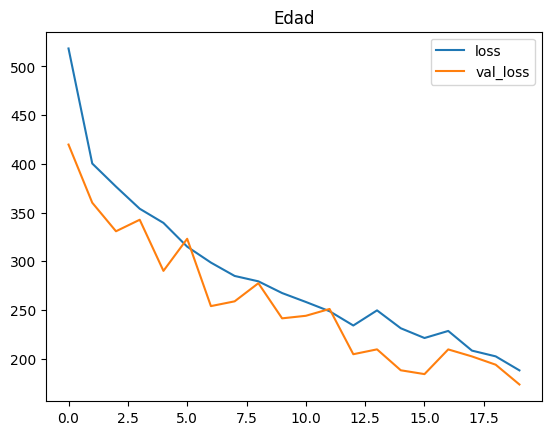

In [13]:
losses_age = pd.DataFrame(history.history)
losses_age[['loss','val_loss']].plot(title='Edad')

### Evaluacion de resultados

In [14]:
y_pred = model.predict(x_test_age)  # Devuelve flotantes por la naturaleza de la capa de salida
y_pred_round = [round(p[0]) for p in y_pred] # Convierto a enteros para poder comparar con los valores de edad que tenemos del dataset

223/223 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import classification_report

# Al hacer esto, comparo edad vs edad, es decir, si predijo 3 la red y en realidad tenía 2 años... se computa como un error de clase
# Qué implicancia tiene esto? Será que conviene algún tipo de transformación? Agrupar algunos rangos por ejemplo? ;)
print(classification_report(y_test_age, y_pred_round))

Una solucion posible es agrupar los datos en clusteres de edad en un rango de 5 años, por ejemplo: de 0 a 5, de 6 a 11, etc.

In [ ]:
# Para contrastar visualmente lo recién planteado...
count=0
STOP = 100
for i in y_test_age:
    print("{} - {}".format(y_pred_round[count], i))
    count+=1
    if count == STOP:
        break

**Una misma RNA ¿Puede predecir más de una característica?**

Sí, una misma red neuronal puede predecir más de una característica. Esto se logra al tener múltiples salidas en la arquitectura de la red neuronal. Cada salida corresponderá a una característica o variable que se desea predecir.

Por ejemplo, en el caso de un modelo que procesa imágenes de personas y se desea predecir tanto la edad como el género de la persona en la imagen, se pueden tener dos salidas en la red neuronal: una para predecir la edad y otra para predecir el género. Cada salida tendría su propia capa de salida con la cantidad adecuada de neuronas y función de activación correspondiente.

Es importante tener en cuenta que al tener múltiples salidas en la red neuronal, se debe ajustar la función de pérdida utilizada durante el entrenamiento para tener en cuenta todas las salidas. Por ejemplo, se puede utilizar una combinación de funciones de pérdida específicas para cada salida o una función de pérdida conjunta que tenga en cuenta las diferentes variables a predecir.

Al permitir que una misma red neuronal prediga múltiples características, se puede aprovechar la capacidad de aprendizaje de la red para realizar tareas más complejas y obtener información más detallada a partir de los datos de entrada.

In [17]:
# Pese a las diferencias que se pueden notar, que depende del tipo y tiempo de entrenamiento...
# Si computamos la media de los valores de salida, deben resultar muy parecidos
# Esto es, por la métrica utilizada
print("Medias: Real {} vs CRNA {}".format(y_test_age.mean(), sum(y_pred)/len(y_pred)))

Medias: Real 33.29035433070866 vs CRNA [30.178995]
